In [1]:
import pandas as pd
import intensity_fill

%matplotlib inline

In [2]:
df = pd.read_csv("ravdess_features.csv")

excluded = [
    "modality",
    # "vocal_channel",
    # "emotional_intensity",
    # "statement",
    "repetition",
    # "actor",
    "channels",
    "sample_width",
    "frame_rate",
    "frame_width",
    "sample_width",
    "stft_max",
    "frame_count",
    "length_ms",
    "mean",
    "max","min",
    # "kur","skew",
]
df = intensity_fill.fill_intensity(df)

categorical = ["sex", "emotion", "emotional_intensity", "vocal_channel", "statement"]
df.drop(columns=excluded, inplace=True)
for field in categorical:
    df[field] = pd.Categorical(df[field]).codes

df.actor[df.actor.isna()] = -1
df.vocal_channel[df.vocal_channel.isna()] = -1

with pd.option_context('display.max_rows', 10, 'display.max_columns', None):  # more options can be specified also
    display(df)

/home/djanloo/Desktop/dynamiting/intensity_fill.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.intensity[df.intensity.isna()] = I_from_std(df["std"][df.intensity.isna()])
/tmp/ipykernel_88672/2698142974.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.actor[df.actor.isna()] = -1
/tmp/ipykernel_88672/2698142974.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.vocal_channel[df.vocal_channel.isna()] = -1


,vocal_channel,emotion,emotional_intensity,statement,actor,sex,intensity,zero_crossings_sum,mfcc_mean,mfcc_std,mfcc_min,mfcc_max,sc_mean,sc_std,sc_min,sc_max,sc_kur,sc_skew,stft_mean,stft_std,stft_min,stft_kur,stft_skew,std,kur,skew
0,1,3,0,0,2.0,0,-36.793432,16995,-33.485947,134.654860,-755.22345,171.69092,5792.550744,3328.055457,0.000000,13541.959028,-1.120769,0.250940,0.415250,0.335533,0.000000,-1.215025,0.403514,0.014482,9.406061,0.273153
1,1,0,0,0,16.0,0,-33.739051,13906,-29.502108,130.485630,-713.98560,205.00770,5197.620555,4040.931570,0.000000,12000.290443,-1.531204,0.219582,0.417488,0.352380,0.000000,-1.384174,0.290905,0.020417,19.564187,0.292157
2,-1,4,1,0,16.0,0,-32.290737,18723,-30.532463,126.577110,-726.06036,165.45653,4830.743037,3332.131300,0.000000,12007.751173,-1.130153,0.436699,0.379758,0.352270,0.000000,-1.242947,0.470350,0.024317,4.881241,0.302659
3,-1,7,0,1,14.0,0,-49.019839,11617,-36.059555,159.725160,-842.94635,190.03609,5376.446478,4053.663073,0.000000,12048.223893,-1.497765,0.098802,0.407277,0.360552,0.000000,-1.445318,0.274756,0.003561,13.040259,-0.081014
4,0,4,1,0,2.0,0,-31.214503,15137,-31.405996,122.125824,-700.70276,161.13400,5146.012474,3442.724109,0.000000,12025.582707,-1.167544,0.496066,0.415974,0.350655,0.000000,-1.366742,0.318926,0.027522,7.485109,0.414872
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2447,1,1,1,1,23.0,1,-45.519766,9871,-30.225578,158.845500,-855.92420,208.18497,5886.647366,4114.260257,0.000000,12210.517144,-1.588861,0.184390,0.573838,0.304496,0.000000,-1.075888,-0.310088,0.005260,9.551363,0.759247
2448,1,1,0,0,23.0,1,-43.342901,8963,-31.160332,157.499700,-825.37410,220.79490,6602.742127,4191.727090,0.000000,12064.561791,-1.614582,-0.113920,0.591010,0.306333,0.000000,-1.026071,-0.408018,0.006836,22.517991,1.073633
2449,0,6,1,0,23.0,1,-36.197674,9765,-26.135280,138.133210,-768.36536,235.53938,4654.156076,4231.511986,0.000000,12207.179884,-1.337419,0.619346,0.467994,0.347843,0.000000,-1.473789,0.130310,0.015384,4.964319,-0.005821
2450,1,7,0,1,-1.0,1,-45.751265,9716,-28.242815,159.943400,-868.09576,219.84350,5524.736973,3596.031841,760.822547,11981.912464,-1.465594,0.206481,0.578854,0.308684,0.001565,-1.277117,-0.242668,0.005182,13.855588,-0.110966


normalization

In [3]:
from sklearn.preprocessing import MinMaxScaler
X = df.values
scaler = MinMaxScaler()
X_minmax = scaler.fit_transform(X)

Manifold knn representation

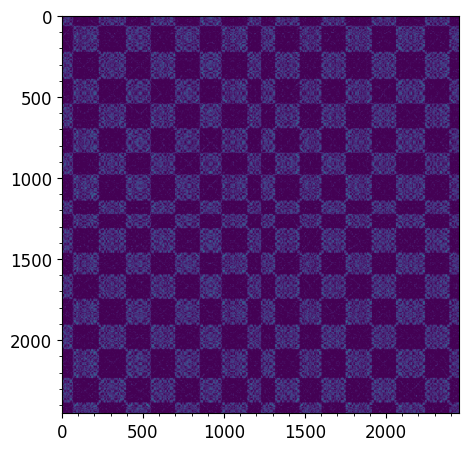

In [4]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
from matplotlib import pyplot as plt
from sklearn.neighbors import kneighbors_graph
k = 300
A = kneighbors_graph(X_minmax,k, mode='distance', include_self=True)
adj = A.toarray()
plt.imshow(adj)

This result is justified by the fact that the sex feature is divided in groups of males and females. This shows that the male cluster is completely disconnected from the female cluster.

So we first compute the spectral embedding over the complete dataset

/home/djanloo/.local/share/virtualenvs/dynamiting-oYIjB6ZE/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:233: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)


(-0.0015960687007188475,
 0.0016377570054069296,
 -0.0015459914156283248,
 0.001953424989659769)

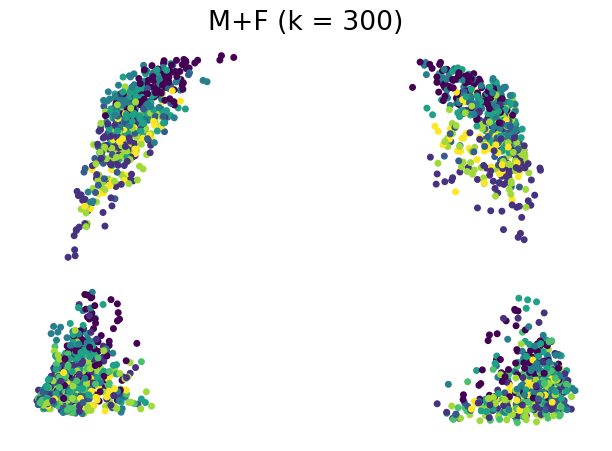

In [5]:
from sklearn.manifold import spectral_embedding
points = spectral_embedding(adj,  
                n_components=2, 
                eigen_tol=0.01, 
                norm_laplacian=True, 
                drop_first=True)
plt.scatter(points[:,0], points[:,1], c=df.emotion)
plt.title(f"M+F (k = {k})")
plt.axis("off")


Then we divide in males and females

In [6]:
males = df[df.sex==1].drop(columns=["emotion"])
Xmales = MinMaxScaler().fit_transform(males.values)

females = df[df.sex==0]
Xfemales = MinMaxScaler().fit_transform(females.values)

# Reduces the importance of emotional intensity
# in knn distance
alpha = 0.0
Xmales[:,1] *= alpha
Xfemales[:,1] *= alpha

/home/djanloo/.local/share/virtualenvs/dynamiting-oYIjB6ZE/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:233: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)


(-0.00222061394604559,
 0.002757623448497223,
 -0.002578178225795986,
 0.0026698005941446935)

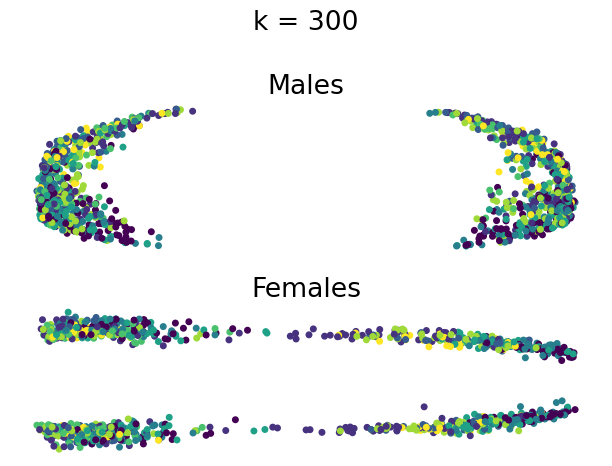

In [7]:
males_adj = kneighbors_graph(Xmales, k, mode='distance', include_self=True).toarray()
females_adj = kneighbors_graph(Xfemales, k, mode='distance', include_self=True).toarray()
male_points = spectral_embedding(males_adj,  
                n_components=2, 
                eigen_tol=0.01, 
                norm_laplacian=True, 
                drop_first=True)
female_points = spectral_embedding(females_adj,  
                n_components=2, 
                eigen_tol=0.01, 
                norm_laplacian=True, 
                drop_first=True)
fig, axes = plt.subplots(2)
map = axes[0].scatter(male_points[:,0], male_points[:,1], c=df.emotion[df.sex==1])
axes[1].scatter(female_points[:,0], female_points[:,1], c=df.emotion[df.sex==0])
axes[0].axis("off")
fig.suptitle(f"k = {k}")
axes[0].set_title("Males")
axes[1].set_title("Females")
axes[1].axis("off")

## Learning from the neighborhood

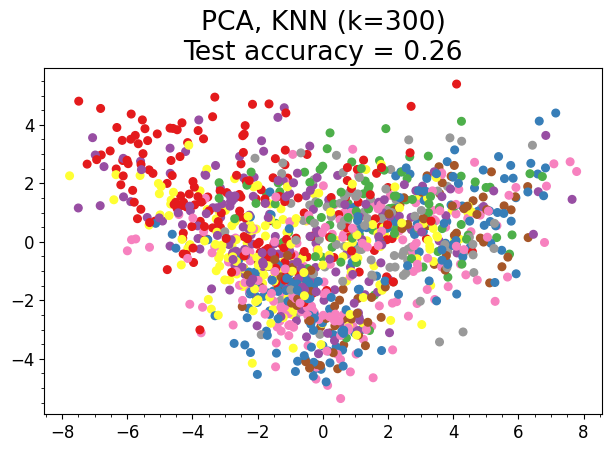

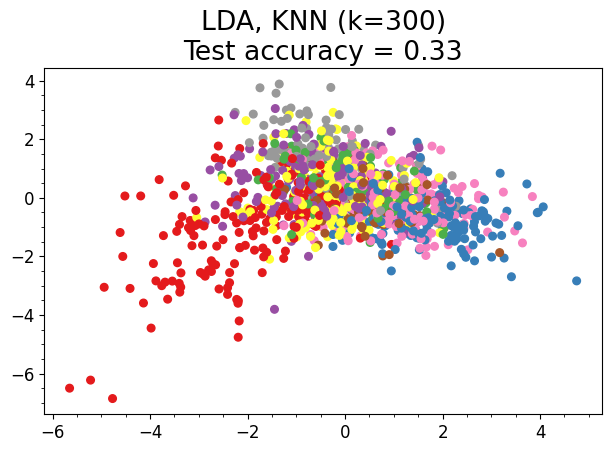

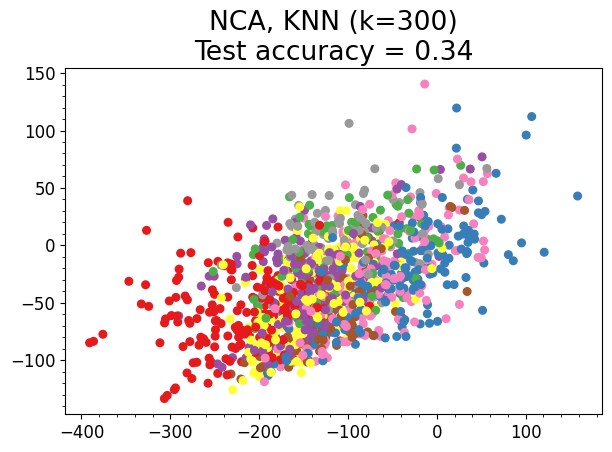

In [8]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

n_neighbors = k
random_state = 0

# Load Digits dataset
X, y = df[df.sex==1].drop(columns=["emotion"]).values, df[df.sex==1].emotion.values

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, stratify=y, random_state=random_state
)

dim = len(X[0])
n_classes = len(np.unique(y))

# Reduce dimension to 2 with PCA
pca = make_pipeline(StandardScaler(), PCA(n_components=2, random_state=random_state))

# Reduce dimension to 2 with LinearDiscriminantAnalysis
lda = make_pipeline(StandardScaler(), LinearDiscriminantAnalysis(n_components=2))

# Reduce dimension to 2 with NeighborhoodComponentAnalysis
nca = make_pipeline(
    MinMaxScaler(),
    NeighborhoodComponentsAnalysis(n_components=2, random_state=random_state),
)

# Use a nearest neighbor classifier to evaluate the methods
knn = KNeighborsClassifier(n_neighbors=n_neighbors)

# Make a list of the methods to be compared
dim_reduction_methods = [("PCA", pca), ("LDA", lda), ("NCA", nca)]

# plt.figure()
for i, (name, model) in enumerate(dim_reduction_methods):
    plt.figure()
    # plt.subplot(1, 3, i + 1, aspect=1)

    # Fit the method's model
    model.fit(X_train, y_train)

    # Fit a nearest neighbor classifier on the embedded training set
    knn.fit(model.transform(X_train), y_train)

    # Compute the nearest neighbor accuracy on the embedded test set
    acc_knn = knn.score(model.transform(X_test), y_test)

    # Embed the data set in 2 dimensions using the fitted model
    X_embedded = model.transform(X)

    # Plot the projected points and show the evaluation score
    plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y, s=30, cmap="Set1")
    plt.title(
        "{}, KNN (k={})\nTest accuracy = {:.2f}".format(name, n_neighbors, acc_knn)
    )
plt.show()


Results are pretty discouraging. I try to use UMAP.

In [9]:
import umap
reducer = umap.UMAP(n_neighbors=100)
X = df.drop(columns=["emotion", "emotional_intensity"])
embedding_males = reducer.fit_transform(X[df.sex==1])
embedding_females = reducer.fit_transform(X[df.sex==0])

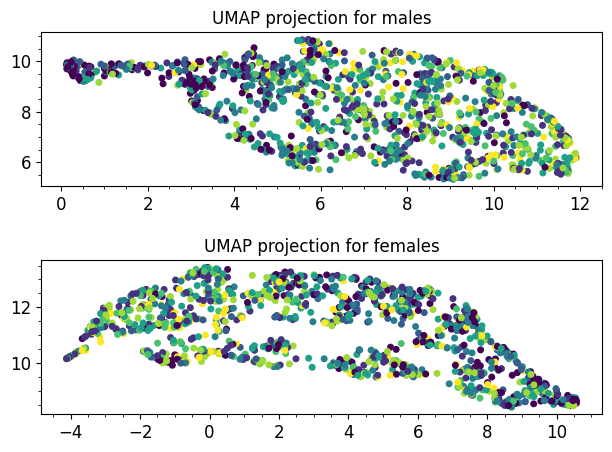

In [11]:
fig, axes = plt.subplots(2)
axes[0].scatter(
    embedding_males[:, 0],
    embedding_males[:, 1],
    c=df.emotion[df.sex==1])
axes[0].set_title('UMAP projection for males', fontsize=12);

axes[1].scatter(
    embedding_females[:, 0],
    embedding_females[:, 1],
    c=df.emotion[df.sex==0])
# plt.gca().set_aspect('equal', 'datalim')
axes[1].set_title('UMAP projection for females', fontsize=12);

(-6.3050719738006595,
 17.01949324607849,
 -6.501164364814758,
 14.422905373573304)

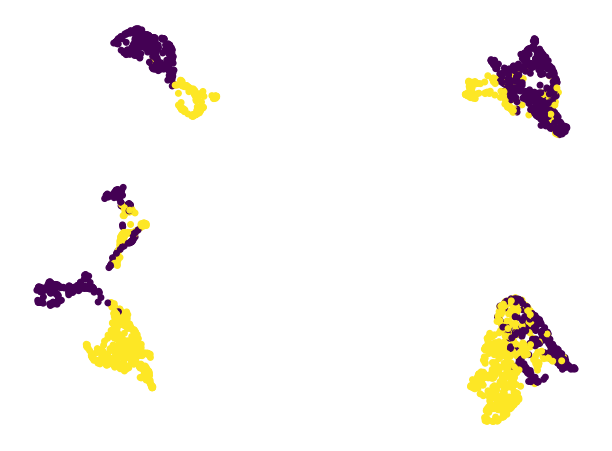

In [27]:
X = df.drop(columns=["sex", "actor","statement", "emotion", "emotional_intensity"])
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
reducer = umap.UMAP(n_neighbors=15)
embedding = reducer.fit_transform(X)
plt.scatter(embedding[:,0], embedding[:,1], c=df.sex)
plt.axis("off")